In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#to import cv2 on your local machine, first run pip install opencv-python
import cv2

In [2]:
base_url= 'D:/Grad_dip/4.Applied Data Analysis/Assessment/Assignment-2/Data/'
train_df = pd.read_csv(base_url + 'trainset_students.csv')
train_df.head()

ID     Label  Label_Confidence
0  818021711  Positive            0.6715
1  911806503  Positive            0.6642
2  882035319  Negative            0.6683
3  880892525   Neutral            0.3360
4  828003448  Positive            1.0000

# EDA

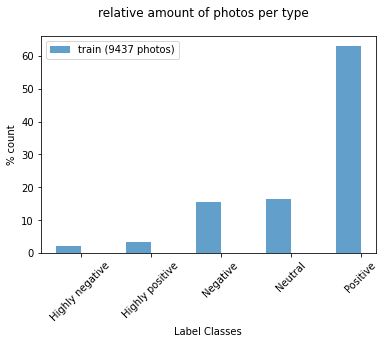

In [15]:
# let's see the label distribution
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('Label Classes')
    plt.ylabel(ylabel_text)

plt.suptitle('relative amount of photos per type')
plot_bar(train_df['Label'], loc='left')
plt.legend([
    'train ({0} photos)'.format(len(train_df['Label']))
]);

looks imbalanced right? you should know by now what that means! let's see some random images with their labels


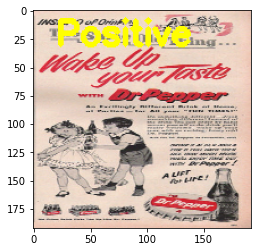

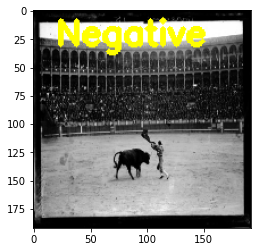

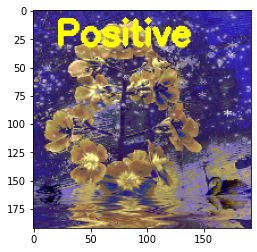

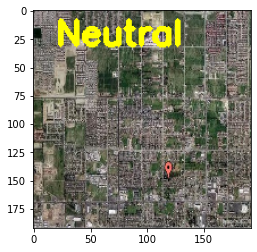

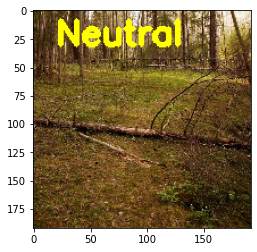

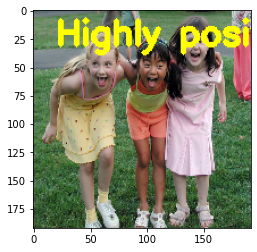

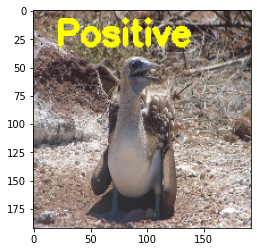

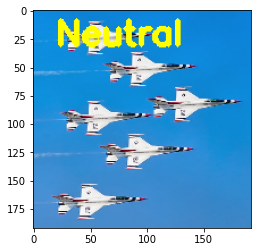

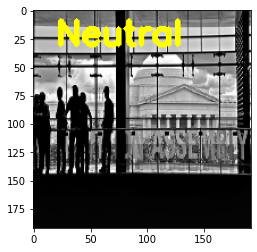

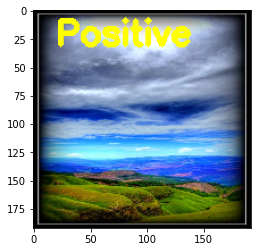

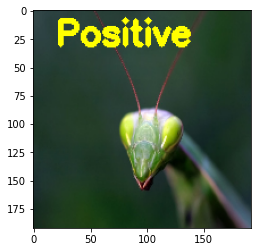

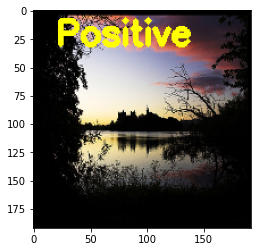

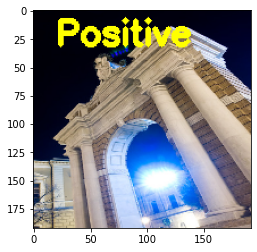

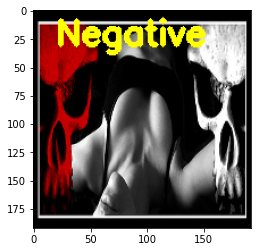

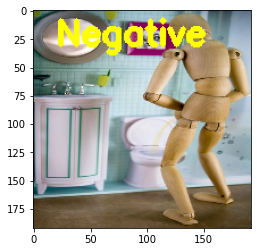

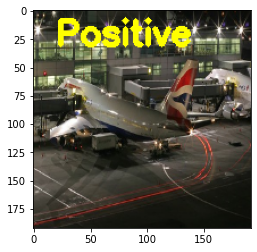

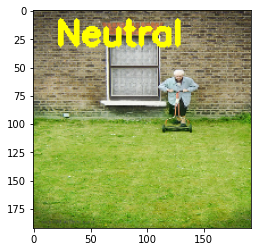

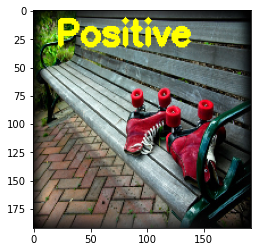

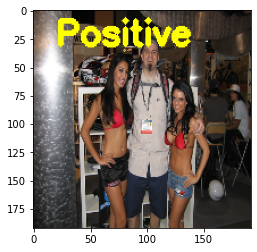

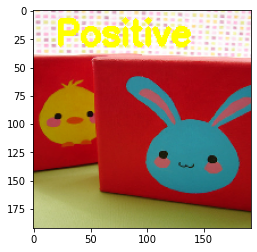

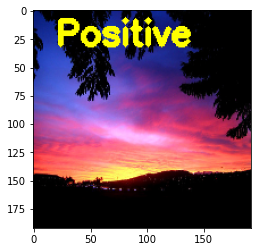

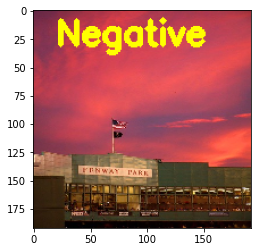

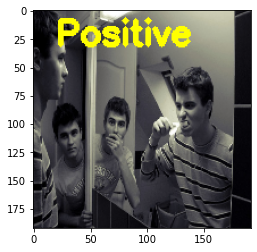

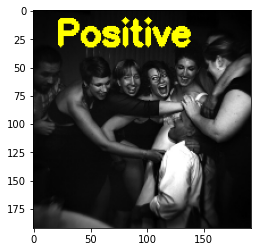

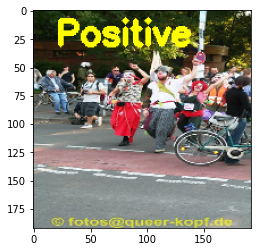

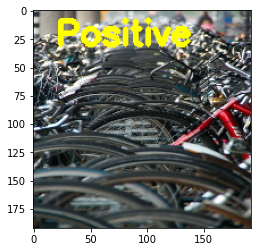

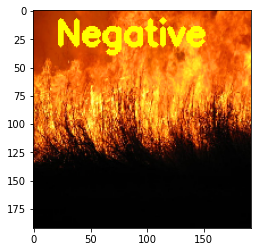

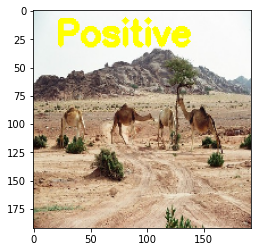

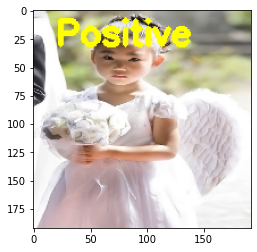

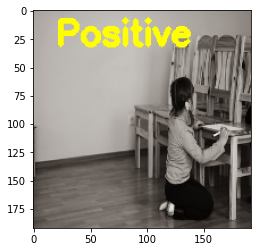

In [16]:
# show 30 random label on image
fixed_size = tuple((192, 192))
for i in np.random.randint(low=0, high = len(train_df), size=30):
    file = base_url + "images/" + str(train_df.iloc[i,0]) + ".jpg"
    
    image = cv2.imread(file)
    image = cv2.resize(image, fixed_size)
    cv2.putText(image, train_df.iloc[i,1], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)
    cv2.putText(image, str(train_df.iloc[i,2]), (320,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

Looks like positive images are very bright having widespread colour-combination. On the other hand,Negative images are in gray scale or black or red coloured. Neutral ones are mostly following a pattern.

In [5]:
# Let's investigate the confidence level distribution for each class.

In [6]:
import plotly.express as px
df =train_df
fig = px.histogram(df, x="Label_Confidence", y="ID", color="Label", facet_col="Label")
fig.show()

We can hardly follow Label confidence distribution for highly positive and highly negative classes from the above facetted bar plot.
So, let's have a look individually only those two classes

(array([104.,   0.,  15.,  12.,  78.,  79.,   1.,   1.,   0.,  13.]),
 array([0.3338 , 0.40042, 0.46704, 0.53366, 0.60028, 0.6669 , 0.73352,
        0.80014, 0.86676, 0.93338, 1.     ]),
 <BarContainer object of 10 artists>)

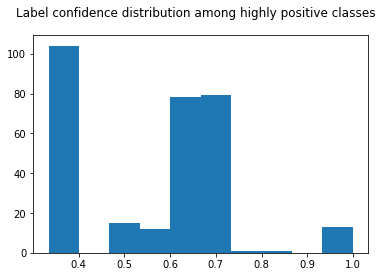

In [7]:
plt.suptitle('Label confidence distribution among highly positive classes')
plt.hist(train_df[train_df.Label=='Highly positive'].Label_Confidence)

(array([54.,  0., 14., 16., 47., 37.,  2.,  5.,  2., 11.]),
 array([0.3342 , 0.40078, 0.46736, 0.53394, 0.60052, 0.6671 , 0.73368,
        0.80026, 0.86684, 0.93342, 1.     ]),
 <BarContainer object of 10 artists>)

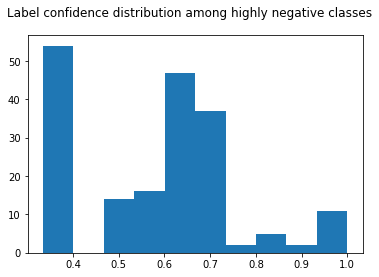

In [8]:
plt.suptitle('Label confidence distribution among highly negative classes')
plt.hist(train_df[train_df.Label=='Highly negative'].Label_Confidence)

In [9]:
train_df.iloc[i,2]

0.6709999999999999

Some interesting observations right? I am not going to keep exploring but you probably should! Think about the color distributions in each class for example.

# Feature Extraction

Feature extraction is performed in two stages:

1) feature extrated from the provided features and 2) feature extracted from the pixels of the images

In [10]:
#!pip install mahotas==1.4.11
#!pip install opencv-python

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from skimage.io import imread, imshow
from skimage import filters
from skimage.filters import prewitt_h,prewitt_v
import mahotas

import cv2
import os

## feature extractors

In [19]:
# feature-descriptor-1: Hu Moments
# here is more info about this feature
# https://learnopencv.com/shape-matching-using-hu-moments-c-python/
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture
# here is more info about this feature
# https://www.nature.com/articles/s41598-017-04151-4

def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature-descriptor-3: Color Histogram
# here is more info about this feature
# https://en.wikipedia.org/wiki/Color_histogram
def fd_histogram(image, mask=None, bins = 8):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

def fd_pixel(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    pixel= np.reshape(image,150*150)
    return pixel

## convert all images to numeric features

In [20]:
# to convert the input image to a fixed size of (500, 500).
# this can take a while on Colab beacuse of the I/O time (around 30 minutes, I stopped it after 20!)
fixed_size = tuple((500, 500))

# empty lists to hold feature vectors and labels
global_features = []
labels = []
confidence = []

# loop over the images
for row in train_df.iterrows():
    # get the image file name
    file = base_url + "images/"  + str(row[1]['ID']) + ".jpg"

    # read the image and resize it to a fixed-size
    image = cv2.imread(file)
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image, bins = 8)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    # global_feature = np.hstack([fv_histogram, fv_hu_moments])

    # update the list of labels and feature vectors
    labels.append(row[1]['Label'])
    confidence.append(row[1]['Label_Confidence'])
    global_features.append(global_feature)

In [21]:
# to convert the input image to a fixed pixel size of (150, 150).

fixed_size = tuple((150, 150))

# empty lists to hold pixel vectors

pixel_feature_list =[]

# loop over the images
for row in train_df.iterrows():
    # get the image file name
    file = base_url + "images/"  + str(row[1]['ID']) + ".jpg"
    # read the image and resize it to a fixed-size
    image = cv2.imread(file)
    image = cv2.resize(image,fixed_size)
    fv_pixel       = fd_pixel(image)
    
    pixel_feature_list.append(fv_pixel)
    

## Preprocessing :  Reading data, feature normalization, label encoding:

In [147]:
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

# encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

# scale features in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
rescaled_pixel = scaler.fit_transform(pixel_feature_list)
print("[STATUS] feature vector and pixel vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

[STATUS] feature vector size (9437, 532)
[STATUS] training Labels (9437,)
[STATUS] training labels encoded...
[STATUS] feature vector and pixel vector normalized...
[STATUS] target labels: [4 4 2 ... 4 0 4]
[STATUS] target labels shape: (9437,)


In [148]:
feature_data = pd.DataFrame(rescaled_features)
df_labels = pd.DataFrame(target)
df_labels.rename(columns = {0:'Label'}, inplace = True)
#pixel_feature = pd.DataFrame(rescaled_pixel)

In [149]:
feature_data.shape

(9437, 532)

In [30]:
# Taking cubic value of for confidence to wight the higher value as cnfi
df_conf = pd.DataFrame(train_df['Label_Confidence']**3)

In [31]:
df = pd.concat([feature_data_train,df_conf], axis=1)
df.head()

0         1         2         3         4         5         6  \
0  0.776460  0.004142  0.025869  0.111169  0.113330  0.002086  0.000724   
1  0.007428  0.000803  0.014841  0.054755  0.162456  0.212114  0.262593   
2  0.009126  0.118956  0.161748  0.140321  0.292609  0.014038  0.067817   
3  0.000732  0.000000  0.000022  0.000034  0.000110  0.000286  0.000535   
4  0.037449  0.000329  0.000472  0.000426  0.000464  0.000242  0.000236   

          7         8         9  ...       523       524       525       526  \
0  0.009833  0.001737  0.004026  ...  0.452897  0.996127  0.114052  0.002887   
1  0.098472  0.000555  0.001591  ...  0.438290  0.998778  0.022461  0.000189   
2  0.053721  0.002986  0.023985  ...  0.632849  0.984479  0.042172  0.000072   
3  0.004058  0.000000  0.000030  ...  0.429705  0.997130  0.087192  0.000092   
4  0.003827  0.002299  0.003443  ...  0.736119  0.949413  0.098226  0.002059   

            527           528       529       530       531  Label_Confidence  
0  1.367616e-03  1.241149e-04  0.003508  0.014614  0.365359          0.302788  
1  4.830601e-07  1.510174e-07  0.003508  0.014634  0.365359          0.293020  
2  5.714888e-06  3.945218e-06  0.003508  0.014634  0.365359          0.298479  
3  4.253518e-06  3.315941e-05  0.003508  0.014635  0.365359          0.037933  
4  1.776578e-04  1.624116e-04  0.003508  0.014655  0.365359          1.000000  

[5 rows x 533 columns]

## SMOTE oversampling to solve imbalanced nature of the data 

In [ ]:
#!pip install imblearn

In [32]:
from imblearn.over_sampling import SMOTE
from collections import Counter
oversample = SMOTE()
X, y = oversample.fit_resample(df, target)

C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Class=4, n=5945 (20.000%)
Class=2, n=5945 (20.000%)
Class=3, n=5945 (20.000%)
Class=1, n=5945 (20.000%)
Class=0, n=5945 (20.000%)


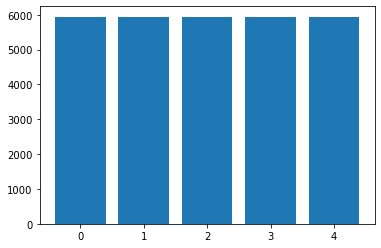

In [33]:
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

# Feature Selection

## Feature selection using recursive feature elemination technique

In [34]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [35]:
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring shows the proportion of correct classifications


rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(2),
    scoring="accuracy",
    min_features_to_select=2,
)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



KeyboardInterrupt: 

## Feature selection using ' feature importance' parameter of a simplified model 

In [36]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

# define the model
model = RandomForestClassifier()

# fit the model
model.fit(X, y)


C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



RandomForestClassifier()

In [109]:
# get importance
importance = model.feature_importances_

# summarize feature importance
Columns = []
column_index =[]
selected_feature_importance = []

for i,v in enumerate(importance):
    if v > 0.006:
        print('Feature: %0d, Score: %.5f' % (i,v))
        Columns.append(X.columns[i])
        column_index.append(i)
        selected_feature_importance.append(v)

print("selected number of features: "+str(len(Columns)))

Feature: 0, Score: 0.00625
Feature: 517, Score: 0.00637
Feature: 524, Score: 0.00657
Feature: 525, Score: 0.00623
Feature: 532, Score: 0.03087
selected number of features: 5


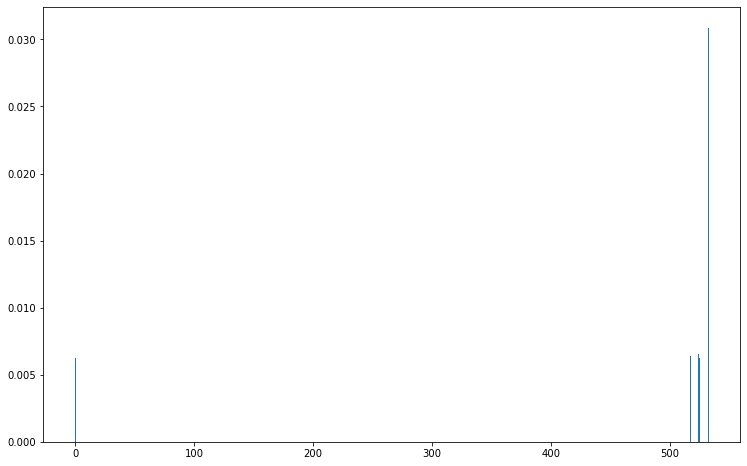

In [110]:
# plot feature importance

#pyplot.bar([x for x in range(len(importance))], importance)
#pyplot.bar([selected_feature[x] for x in range(len(selected_feature_importance))], selected_feature_importance)
plt.rcParams['figure.figsize'] = (12.5, 8.0)
pyplot.bar(column_index, selected_feature_importance)
pyplot.show()

In [113]:
X1=X[Columns]
X1.shape

(29725, 5)

## Feature selction using ElasticNet classifier

In [41]:
# import model
from sklearn.linear_model import ElasticNet
 

In [42]:
def elastic_net(X, y, alpha, models_to_plot={}):
    #Fit the model
    elasreg = ElasticNet(alpha=alpha,normalize=True, max_iter=1e5)
    elasreg.fit(X,y)
    y_pred = elasreg.predict(X)

    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(X,y_pred)
        plt.plot(X,y,'.')
        plt.title('Plot for alpha: %.3g'%alpha)

    #Return the result in pre-defined format
    rss = sum((y_pred-y)**2)
    ret = [rss]
    ret.extend([elasreg.intercept_])
    ret.extend(elasreg.coef_)
    return ret

C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.

C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning:

Feature names only support names that are all strings. Got feature names with d

C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other

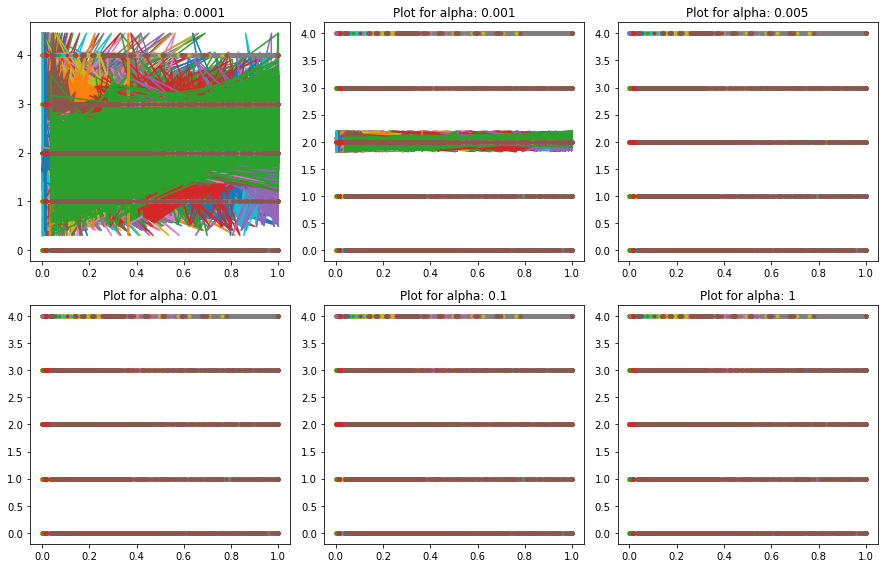

In [43]:
# Defining the alpha values to test
alpha_elastic = [1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,1]

# Initializing the dataframe to store coefficients
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(len(X.columns))]
ind = ['alpha_%.2g'%alpha_elastic[i] for i in range(0,10)]
coef_matrix_elasnet = pd.DataFrame(index=ind, columns=col)

# Defining the models to plot
models_to_plot = {1e-4:231, 1e-3:232,5e-3:233, 1e-2:234, 1e-1:235, 1:236}

# Iterating over the 7 alpha values:
for i in range(10):
    coef_matrix_elasnet.iloc[i,] = elastic_net(X, y, alpha_elastic[i], models_to_plot);

In [102]:
# Train the model
elasclass = ElasticNet(alpha = .01)
elasclass.fit(X,y)
 
# calculate the prediction and mean square error
y_pred1 = elasclass.predict(X)#elasreg.predict(X_valid)
mean_squared_error1 = np.mean((y_pred1 - y)**2)
print("Mean Squared Error on validation set", mean_squared_error1)
 
elasclass_coeff = pd.DataFrame()
elasclass_coeff["Columns"] = X.columns
elasclass_coeff['Coefficient Estimate'] = pd.Series(abs(elasclass.coef_))

C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Mean Squared Error on validation set 1.6611431516459798


C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



In [114]:
elasclass_coeff_final= elasclass_coeff[elasclass_coeff['Coefficient Estimate']>.15]
print("selected number of features: "+str(len(elasclass_coeff_final)))
print("selected features and corresponding coefficients are: ")
elasclass_coeff_final

selected number of features: 5
selected features and corresponding coefficients are: 


Columns  Coefficient Estimate
0                   0              0.301785
5                   5              0.343398
7                   7              0.162406
32                 32              0.198147
532  Label_Confidence              1.689996

Text(0.5, 1.0, 'Feature importance using Elastic-net Model')

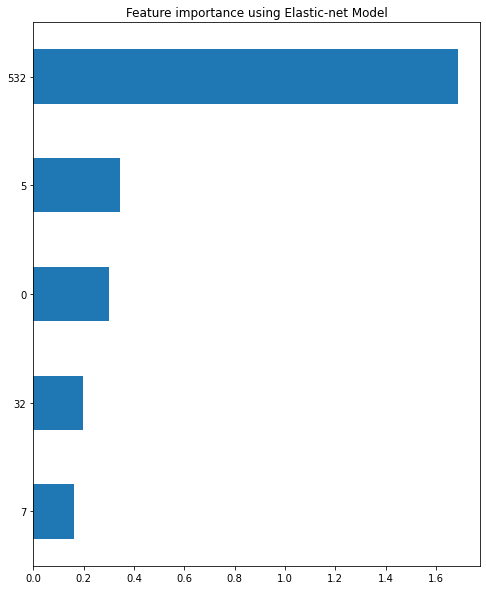

In [104]:
import matplotlib
imp_coef = elasclass_coeff_final['Coefficient Estimate'].sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Elastic-net Model")

In [115]:
X2=X.loc[:,elasclass_coeff_final["Columns"]]
X2.shape

(29725, 5)

# Creating training and test data set

In [67]:
from sklearn.model_selection import train_test_split

## Creating first train and test data-set using features identified by 'feature importance':

In [116]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y,test_size=.3, shuffle=True,random_state=42)

## Creating second train and test data-set using features identified by ElasticNet:

In [117]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y,test_size=.3, shuffle=True,random_state=42)

# Model development

In [69]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
#from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
seed=101

## Random Forest Classification Model

In [118]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = range(1,10,2)
# Minimum number of samples required at each leaf node
min_samples_leaf = range(1,10,2)
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight' : ['balanced', 'balanced_subsample', 'None'],
               'bootstrap': bootstrap,
               'criterion' :['gini', 'entropy']
         }
print(params)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': range(1, 10, 2), 'min_samples_leaf': range(1, 10, 2), 'class_weight': ['balanced', 'balanced_subsample', 'None'], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']}


### First RF Model Based on First Features-Set 

In [ ]:
'''
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = seed)
# Grid search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
CV_rf1 = GridSearchCV(estimator=rf, param_grid=params, cv= 5, verbose=2, n_jobs = -1)
# Fit the random search model
CV_rf1.fit(X1_train, y1_train)
CV_rf1.best_params_
rf1=RandomForestClassifier(
        random_state=seed, max_features='auto', n_estimators= 200, 
        max_depth=8, criterion='gini')
rf1.fit(x_train, y_train)
'''

In [119]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf1 = RandomizedSearchCV(estimator = rf, param_distributions = params, 
                               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [120]:
rf1.fit(X1_train, y1_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning:


245 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
170 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 367, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 748, in _validate_y_class_weight
    raise ValueError(
Val

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         'None'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': range(1, 10, 2),
                                        'min_samples_split': range(1, 10, 2),
                                        'n_estimators': [200, 400, 600, 800,

In [121]:
rf1.best_params_ 

{'n_estimators': 800,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40,
 'criterion': 'entropy',
 'class_weight': 'balanced',
 'bootstrap': False}

In [122]:

import pickle
base_url_models='D:/Grad_dip/4.Applied Data Analysis/Assessment/Assignment-2/models/'
# save the model to disk
filename = base_url_models+'rf2_git1.sav'
pickle.dump(rf1, open(filename, 'wb'))


In [ ]:
'''
import pickle
base_url_models='D:/Grad_dip/4.Applied Data Analysis/Assessment/Assignment-2/models/'
filename = base_url_models+'rf_git1.sav'
rf1 = pickle.load(open(filename, 'rb'))
'''

In [123]:
pred=rf1.predict(X1_test)

C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



In [124]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y1_test,pred))

Accuracy for Random Forest on CV data:  0.6870374523435748


### Second RF Model Based on Second Features-Set 

In [125]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf2 = RandomizedSearchCV(estimator = rf, param_distributions = params, 
                               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [126]:
rf2.fit(X2_train, y2_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning:


245 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
170 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 367, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 748, in _validate_y_class_weight
    raise ValueError(
Val

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         'None'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': range(1, 10, 2),
                                        'min_samples_split': range(1, 10, 2),
                                        'n_estimators': [200, 400, 600, 800,

In [127]:
import pickle
base_url_models='D:/Grad_dip/4.Applied Data Analysis/Assessment/Assignment-2/models/'
# save the model to disk
filename = base_url_models+'rf2_git2.sav'
pickle.dump(rf2, open(filename, 'wb'))

In [ ]:
'''
import pickle
base_url_models='D:/Grad_dip/4.Applied Data Analysis/Assessment/Assignment-2/models/'
filename = base_url_models+'rf_git2.sav'
rf1 = pickle.load(open(filename, 'rb'))
'''

In [128]:
pred=rf2.predict(X2_test)

C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



In [129]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y2_test,pred))

Accuracy for Random Forest on CV data:  0.696120206324288


## XGB model:

In [145]:
#Selecting softmax as the objrective as the problem is about multi-classification

In [146]:
xgb = XGBClassifier( objective='multi:softmax',n_class=5,
                    silent=True)

In [132]:
params = {
        'booster':['gbtree','gblinear']
        'n_estimators':range(100,2000,100),
        'eta' : [.001,.01,.1, .2, .5, 1], #learning_rate
        'min_child_weight': range(1,10,2),
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [.4, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
        'max_depth': range(1,10,2),
        'class_weight' : ['balanced', 'balanced_subsample', 'None'],
        }

In [133]:
folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

### First XGB model based on first feature set

In [134]:
xgb_1 = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, n_jobs=-1, 
                                   cv=skf.split(X1_train, y1_train),
                                   scoring='accuracy', verbose=3, random_state=seed )

xgb_1.fit(X1_train, y1_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\snk_n\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[23:50:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "class_weight", "n_class", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:50:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000024B53AF23C0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           mi...
                   n_iter=5, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample',
                                  

In [135]:
print('\n Best estimator:')
print(xgb_1.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(xgb_1.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(xgb_1.best_params_)


 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, gamma=1.5, gpu_id=-1,
              importance_type=None, interaction_constraints='', learning_rate=1,
              max_delta_step=0, max_depth=9, min_child_weight=9, missing=nan,
              monotone_constraints='()', n_class=5, n_estimators=1100, n_jobs=1,
              nthread=1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, silent=True, subsample=1.0, ...)

 Best normalized gini score for 5-fold search with 5 parameter combinations:
0.13250282565933102

 Best hyperparameters:
{'subsample': 1.0, 'n_estimators': 1100, 'min_child_weight': 9, 'max_depth': 9, 'learning_rate': 1, 'gamma': 1.5, 'colsample_bytree': 1.0, 'class_weight': 'balanced'}


In [136]:
# This part is for saving the model as pickling does not work on xgb object and 
# save_model() does not work with randomizedSearchCV  :
xgb_model1=xgb_1.best_estimator_
xgb_model1.fit(X1_train, y1_train)
xgb_model1.save_model(base_url_models+'xgb1_git1.json')

[23:53:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "class_weight", "n_class", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:53:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
'''
xgb_1 = XGBClassifier()
xgb_1.load_model(base_url_models+"xgb1_git1.json")
'''

In [137]:
pred=xgb_1.predict(X1_test)

In [138]:
print("Accuracy for XGB model on CV data: ",accuracy_score(y1_test,pred))

Accuracy for XGB model on CV data:  0.6036106750392465


### Second XGB model based on Second feature set

In [139]:
xgb_2 = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, n_jobs=-1, 
                                   cv=skf.split(X2_train, y2_train),
                                   scoring='accuracy', verbose=3, random_state=seed )

xgb_2.fit(X2_train, y2_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\snk_n\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[01:36:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "class_weight", "n_class", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:36:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000024B53AF2DD0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           mi...
                   n_iter=5, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample',
                                  

In [140]:
print('\n Best estimator:')
print(xgb_2.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(xgb_2.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(xgb_2.best_params_)


 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, gamma=1.5, gpu_id=-1,
              importance_type=None, interaction_constraints='', learning_rate=1,
              max_delta_step=0, max_depth=9, min_child_weight=9, missing=nan,
              monotone_constraints='()', n_class=5, n_estimators=1100, n_jobs=1,
              nthread=1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, silent=True, subsample=1.0, ...)

 Best normalized gini score for 5-fold search with 5 parameter combinations:
0.16816437293691067

 Best hyperparameters:
{'subsample': 1.0, 'n_estimators': 1100, 'min_child_weight': 9, 'max_depth': 9, 'learning_rate': 1, 'gamma': 1.5, 'colsample_bytree': 1.0, 'class_weight': 'balanced'}


In [142]:
# This part is for saving the model as pickling does not work on xgb object and 
# save_model() does not work with randomizedSearchCV  :
xgb_model2=xgb_2.best_estimator_
xgb_model2.fit(X2_train, y2_train)
xgb_model2.save_model(base_url_models+'xgb1_git2.json')

[01:42:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "class_weight", "n_class", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:42:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
'''
xgb_2 = XGBClassifier()
xgb_2.load_model(base_url_models+"xgb1_git2.json")
'''

In [143]:
pred=xgb_2.predict(X2_test)

In [144]:
print("Accuracy for XGB model on CV data: ",accuracy_score(y2_test,pred))

Accuracy for XGB model on CV data:  0.6082081184122
